## Nesterov Accelerated Gradient

In this section, we look at how Nesterov's Accelerated Gradient (NAG) performs as our optimizer. This is partly inspired by [Sutskever et al. 2013](http://proceedings.mlr.press/v28/sutskever13.pdf) and [this stackoverflow](https://stackoverflow.com/questions/50774683/how-is-nesterovs-accelerated-gradient-descent-implemented-in-tensorflow) post on [TensorFlow's implementation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) of NAG.

### Theory vs Implementation

It is worth noting that the original NAG uses momentum to update weights. So for a weight $\theta_t$, a loss function that we are minimizing $f(theta_t)$ with gradient $\nabla f(\theta_t)$, momentum $\mu \in [0,1]$, learning rate $\epsilon$, and velocity $v_t$:

$$
\begin{eqnarray}
v_{t+1} &=& \mu v_t + \epsilon \nabla f(\theta_t + \mu vt) \\
\theta_{t+1} &=& \theta_t + v_{t+1} 
\end{eqnarray}
$$

However, TensorFlow uses an approximation of this, which is described in the Sutskever paper as Classical Momentum (CM), given by:

$$
\begin{eqnarray}
v_{t+1} &=& \mu v_t + \epsilon \nabla f(\theta_t) \\
\theta_{t+1} &=& \theta_t + v_{t+1}
\end{eqnarray}
$$

This serves as an approximation to NAG which holds for $\mu \approx 1$ and gradient condition $\nabla f(\theta_t) <<< \mu v_t$. However, the latter approximation does not always hold, though we can rectify this to some extent by choosing a very small learning rate $\epsilon$. Depending on the nature of our dataset, this may mean that the learning rate has to be so small for our gradient condition to be met that a true NAG optimizer would end up being slower. As a result, we will optimise for learning rate to pick the best-performing option, though this may mean that we end up with $\epsilon$ too large for our optimiser to be a true NAG optimiser.

This may mean that our results are not ideal compared to a true NAG optimiser, but we should hopefully see faster convergence than traditional gradient descent. Namely, NAG should converge at rate $\frac{1}{k^2}$ compared to traditional gradient descent which converges at $\frac{1}{k}$ where k is the number of steps taken.

We note also that NAG should theoretically shine more when the learning procedure takes more steps to converge to some optima, i.e. where the data is such that deep learning is truly needed and is not quickly/easily optimised by shallow learning methods as in that case our neural network would converge in very small values of $k$ such that $k$ and $k^2$ would not be easily distinguishable.

In [8]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

#### Load Data

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_test = pd.read_csv('..\data\X_test.csv')
y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')
y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

## Training

Train binary on adam optimizer

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10], op = 'adam', metrics = ['accuracy']):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10], op = 'adam', metrics = ['accuracy']):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(num_classes, activation = 'softmax'))
    
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

Train binary and multiclass models for NAG, SGD, and Adam.

In [5]:
count = 1

start = time.time()

#5 learning rates equally spaced between 1/10,000 and 1/100
for eps in np.linspace(1/10000,1/100,5):
    
    eps = round(eps,5)
    #create the 3 optimizer with learning rate above
    # sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
                                      # momentum = 0.9,
                                      # nesterov = False)

    nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
                                      momentum = 0.9, 
                                      nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.Adam(learning_rate = eps)

    #fit same model architecture for each optimizer
    for opt in ['nag']:#,'sgd','adam']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #record model history fitting to binary training data with validation split
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_split = 0.2,
                                              epochs = 30, batch_size = 10000)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
        
        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_split = 0.2,
                                                  epochs = 30, batch_size = 10000)
    
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
        del categ_model_temp
        del categ_history_temp
        print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to nag optimizer with learning rate 0.0001----------
Epoch 1/30
36/36 [==============================] - 2s 21ms/step - loss: 0.5162 - accuracy: 0.6494 - val_loss: 0.4673 - val_accuracy: 0.8332
Epoch 2/30
36/36 [==============================] - 0s 13ms/step - loss: 0.4410 - accuracy: 0.8021 - val_loss: 0.4047 - val_accuracy: 0.8357
Epoch 3/30
36/36 [==============================] - 0s 13ms/step - loss: 0.3981 - accuracy: 0.8058 - val_loss: 0.3678 - val_accuracy: 0.8368
Epoch 4/30
36/36 [==============================] - 0s 13ms/step - loss: 0.3644 - accuracy: 0.8065 - val_loss: 0.3396 - val_accuracy: 0.8373
Epoch 5/30
36/36 [==============================] - 0s 13ms/step - loss: 0.3386 - accuracy: 0.8069 - val_loss: 0.3165 - val_accuracy: 0.8379
Epoch 6/30
36/36 [==============================] - 0s 14ms/step - loss: 0.3150 - accuracy: 0.8076 - val_loss: 0.2956 - val_accuracy: 0.8388
Epoch 7/30
36/36 [==============================] - 1s 14ms/step - los

In [6]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  206.538803 seconds


In [10]:
for eps in np.linspace(1/10000,1/100,5):
    eps = round(eps,5)
    print(eps)

0.0001
0.00258
0.00505
0.00753
0.01


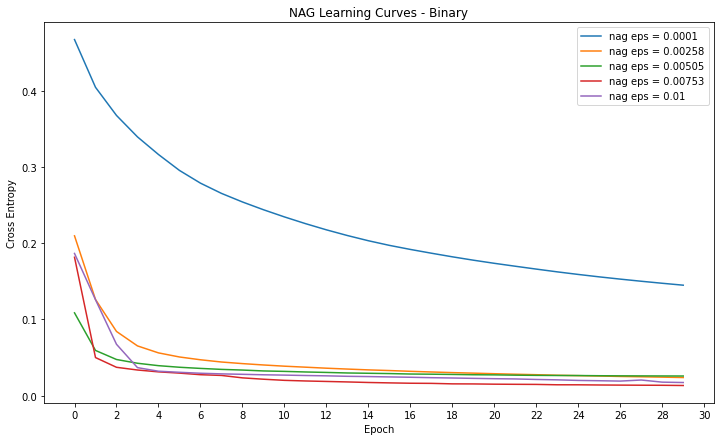

In [17]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(nag_bin_history_1.history['val_loss'],label='nag eps = 0.0001')
plt.plot(nag_bin_history_2.history['val_loss'],label='nag eps = 0.00258')
plt.plot(nag_bin_history_3.history['val_loss'],label='nag eps = 0.00505')
plt.plot(nag_bin_history_4.history['val_loss'],label='nag eps = 0.00753')
plt.plot(nag_bin_history_5.history['val_loss'],label='nag eps = 0.01')

plt.legend()
plt.show()

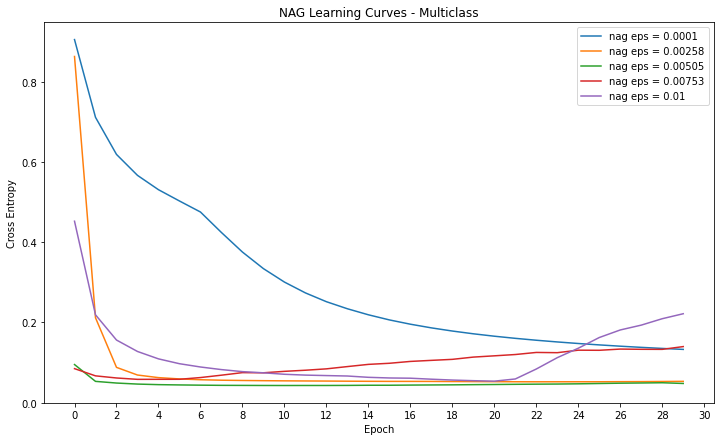

In [18]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(nag_categ_history_1.history['val_loss'],label='nag eps = 0.0001')
plt.plot(nag_categ_history_2.history['val_loss'],label='nag eps = 0.00258')
plt.plot(nag_categ_history_3.history['val_loss'],label='nag eps = 0.00505')
plt.plot(nag_categ_history_4.history['val_loss'],label='nag eps = 0.00753')
plt.plot(nag_categ_history_5.history['val_loss'],label='nag eps = 0.01')

plt.legend()
plt.show()

**Val vs train**

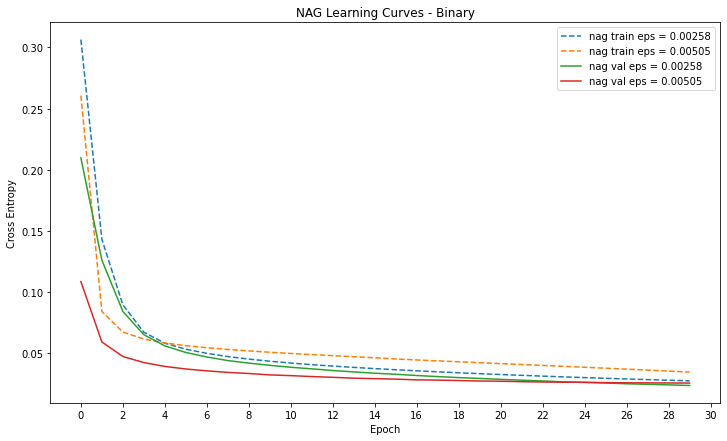

In [20]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(nag_bin_history_2.history['loss'],label='nag train eps = 0.00258',ls='--')
plt.plot(nag_bin_history_3.history['loss'],label='nag train eps = 0.00505',ls='--')

plt.plot(nag_bin_history_2.history['val_loss'],label='nag val eps = 0.00258')
plt.plot(nag_bin_history_3.history['val_loss'],label='nag val eps = 0.00505')

plt.legend()
plt.show()

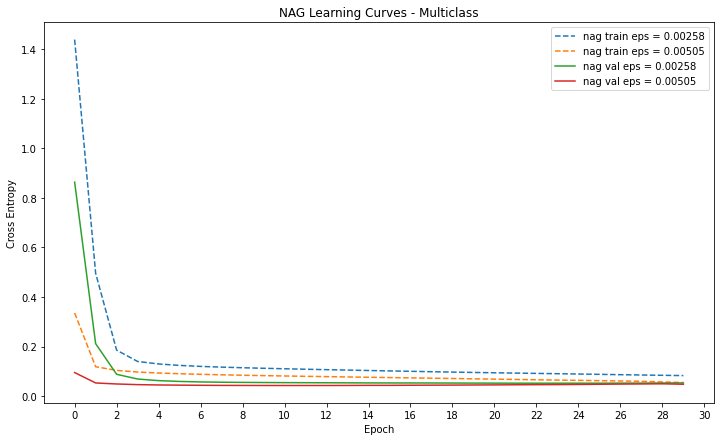

In [22]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(nag_categ_history_2.history['loss'],label='nag train eps = 0.00258', ls = '--')
plt.plot(nag_categ_history_3.history['loss'],label='nag train eps = 0.00505', ls = '--')

plt.plot(nag_categ_history_2.history['val_loss'],label='nag val eps = 0.00258')
plt.plot(nag_categ_history_3.history['val_loss'],label='nag val eps = 0.00505')

plt.legend()
plt.show()

## Plots

In [17]:
import matplotlib.pyplot as plt

#### Binary

Plot adam vs NAG $\epsilon$ = 0.01 vs NAG $\epsilon$ = 0.001 for the binary classifier case

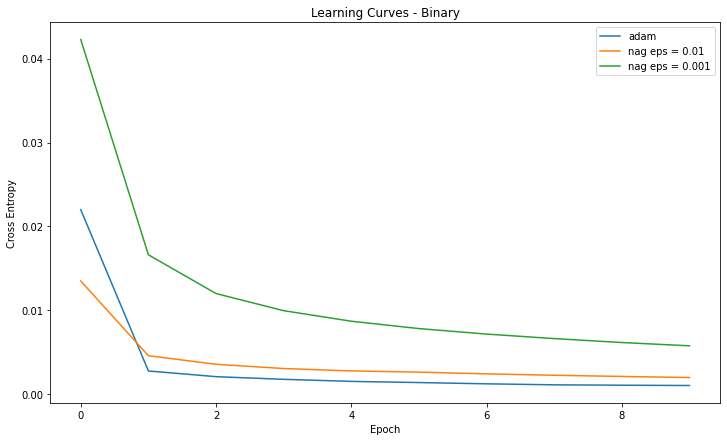

In [18]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(history_adam.history['loss'],label='adam')
plt.plot(history_nag_1.history['loss'],label='nag eps = 0.01')
plt.plot(history_nag_2.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Inspect first 5 epochs

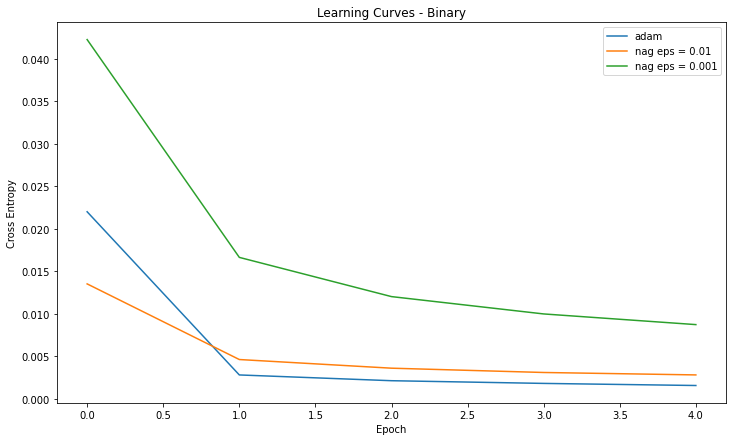

In [19]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')

plt.plot(history_adam.history['loss'][:5],label='adam')
plt.plot(history_nag_1.history['loss'][:5],label='nag eps = 0.01')
plt.plot(history_nag_2.history['loss'][:5],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Inspect final 15 epochs

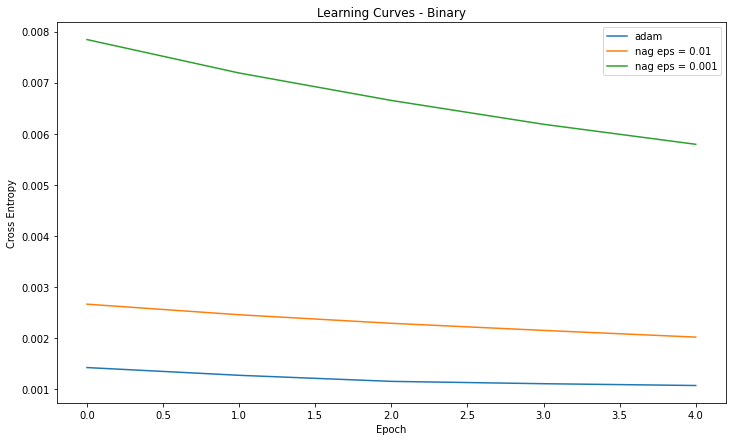

In [20]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')

plt.plot(history_adam.history['loss'][5:],label='adam')
plt.plot(history_nag_1.history['loss'][5:],label='nag eps = 0.01')
plt.plot(history_nag_2.history['loss'][5:],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

#### Multiclass

Plot adam vs NAG $\epsilon$ = 0.01 vs NAG $\epsilon$ = 0.001 for the multiclass case

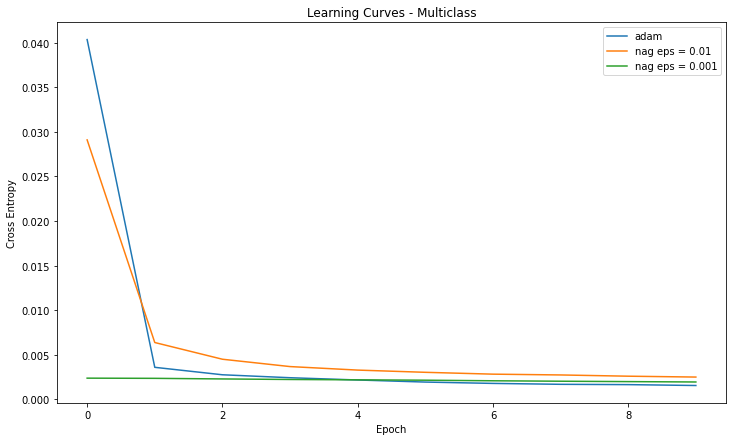

In [21]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(history_adam_multi.history['loss'],label='adam')
plt.plot(history_nag_multi_1.history['loss'],label='nag eps = 0.01')
plt.plot(history_nag_multi_2.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Plot first 5 epochs

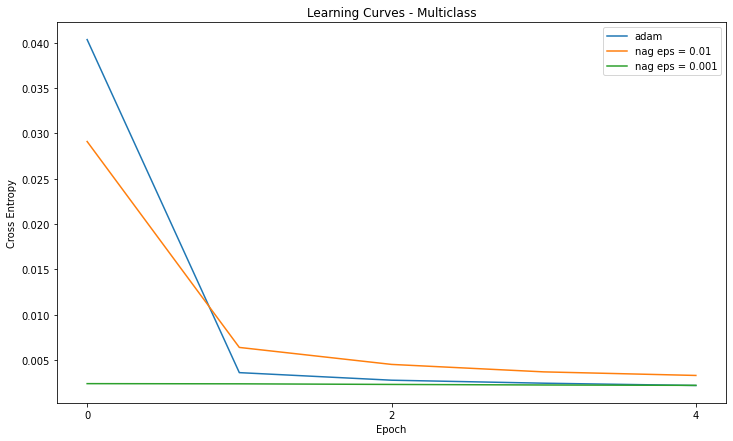

In [22]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(history_adam_multi.history['loss'][:5],label='adam')
plt.plot(history_nag_multi_1.history['loss'][:5],label='nag eps = 0.01')
plt.plot(history_nag_multi_2.history['loss'][:5],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Plot last 15 epochs

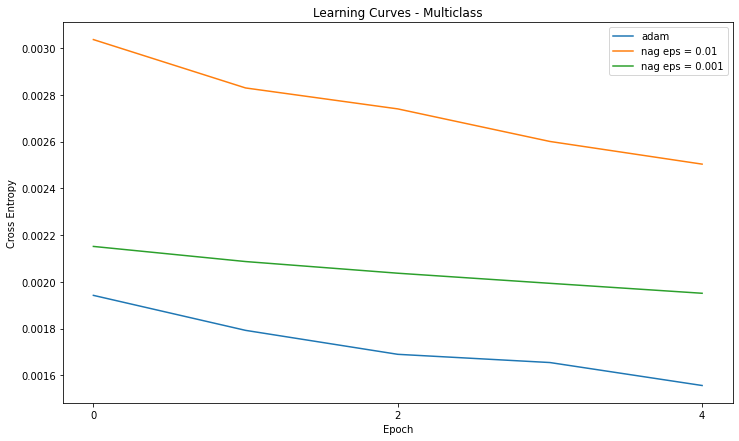

In [23]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(history_adam_multi.history['loss'][5:],label='adam')
plt.plot(history_nag_multi_1.history['loss'][5:],label='nag eps = 0.01')
plt.plot(history_nag_multi_2.history['loss'][5:],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

## Test

Test data

In [30]:
X_test = test_data[test_data.columns[:-2]]

#grab connection_category (normal vs dos vs u2r etc.)
test_targ = test_data.connection_category.copy()
#convert to numeric 0 normal, 1 attack
Y_test = test_targ.apply(lambda x: 0 if x=='normal' else 1)

Multiclass training (normal = `[1,0,0,0,0]`, u2r = `[0,1,0,0,0]` etc.)

In [27]:
Y_test_multi = pd.factorize(test_targ)[0]
Y_test_multi = tf.keras.utils.to_categorical(Y_test_multi,5)

In [64]:
adam_pred = nn_model1.predict(X_test,batch_size=1000)

In [65]:
adam_pred

array([[6.4400569e-06],
       [2.5367484e-05],
       [1.7445783e-06],
       ...,
       [1.0935867e-06],
       [1.3062875e-07],
       [9.2790579e-08]], dtype=float32)

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [58]:
def plotROC(y_true,y_pred,title='Title'):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    plt.subplots(1, figsize=(12,7))

    plt.title(title)
    plt.plot(fpr, tpr)
    
    #plot y=x line for comparison
    plt.plot([0, 1], ls="--")
    #create right-angle shape indiciative of a perfect model
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    prob = roc_auc_score(y_true, y_pred)
    print('      ROC AUC Score: {:.4f}'.format(prob))

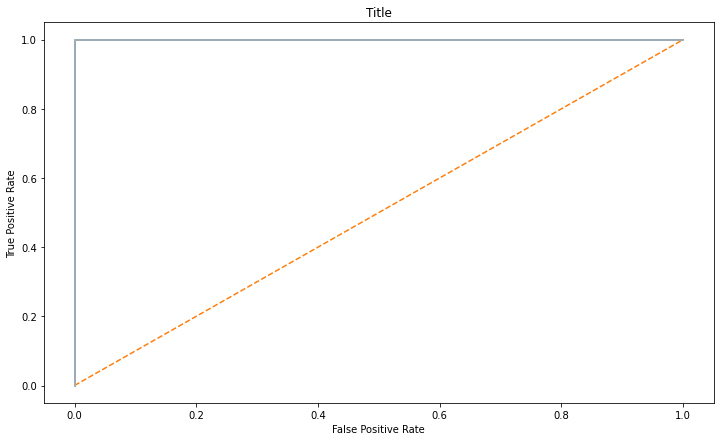

      ROC AUC Score: 1.0000


In [66]:
plotROC(Y_test,adam_pred)

In [67]:
adam_pred

array([[6.4400569e-06],
       [2.5367484e-05],
       [1.7445783e-06],
       ...,
       [1.0935867e-06],
       [1.3062875e-07],
       [9.2790579e-08]], dtype=float32)

In [74]:
binary_adam_pred = adam_pred
binary_adam_pred[binary_adam_pred<0.5]=0
binary_adam_pred[binary_adam_pred>0.5]=1
binary_adam_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [42]:
from sklearn.metrics import confusion_matrix

In [75]:
confusion_matrix(Y_test,binary_adam_pred)

array([[ 9733,     7],
       [   12, 39651]], dtype=int64)

Test multiclass on adam optimizer

In [ ]:
categ_model

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

In [14]:
categ_model = Sequential()
categ_model.add(Input(shape=X_train.shape[1],))
categ_model.add(Dense(10,activation='relu'))
categ_model.add(Dense(10,activation='relu'))
categ_model.add(Dense(5,activation='softmax'))
categ_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history_adam_multi = categ_model.fit(X_train,Y_train_multi,epochs=20,batch_size=1000)

Epoch 1/20
445/445 [==============================] - 3s 7ms/step - loss: 0.3265 - accuracy: 0.9014
Epoch 2/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0332 - accuracy: 0.9903
Epoch 3/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0186 - accuracy: 0.9952
Epoch 4/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0118 - accuracy: 0.9971
Epoch 5/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0086 - accuracy: 0.9984
Epoch 6/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0070 - accuracy: 0.9988
Epoch 7/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0060 - accuracy: 0.9989
Epoch 8/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0048 - accuracy: 0.9991
Epoch 9/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0041 - accuracy: 0.9992
Epoch 10/20
445/445 [==============================] - 3s 7ms/step - loss: 0.0037 - accuracy: 0.9993

Test on NAG mwith varying learning rates

In [15]:
count = 1

for eps in [0.01,0.001]:
    
    #create optimizer with learning rate above
    opt = tf.keras.optimizers.SGD(learning_rate = eps, 
                                  momentum = 0.9, 
                                  nesterov = True)

    #same parameters as before, only changing optimizer
    nn_model2 = createDNN(X = X_train, 
                          hidden_nodes = [10,10,1],
                          activations = ['relu','relu','sigmoid'],
                          loss = 'binary_crossentropy',
                          optimizer=opt,
                          metric='accuracy')
    
    #same as before for categ
    categ_model = Sequential()
    categ_model.add(Input(shape=X_train.shape[1],))
    categ_model.add(Dense(10,activation='relu'))
    categ_model.add(Dense(10,activation='relu'))
    categ_model.add(Dense(5,activation='softmax'))
    categ_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    #better preview
    print('-'*5 + 'binary learning rate ' + str(eps) +5*'-')
    #fit the model in same manner as for adam
    history = nn_model2.fit(X_train,Y_train,epochs=20,batch_size=100)
    print()

    #create a variable called history_nag_i for each learning rate where i == count
    locals()['history_nag_{}'.format(count)] = history
    
    #better preview
    print('-'*5 + 'multi learning rate ' + str(eps) +5*'-')
    #fit the model in same manner as for adam
    history_multi = categ_model.fit(X_train,Y_train_multi,epochs=20,batch_size=100)
    print()

    #create a variable called history_nag_i for each learning rate where i == count
    locals()['history_nag_multi_{}'.format(count)] = history_multi
    
    
    #increase count for next iteration
    count += 1

-----binary learning rate 0.01-----
Epoch 1/20
4447/4447 [==============================] - 30s 7ms/step - loss: 0.0138 - accuracy: 0.9954
Epoch 2/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0052 - accuracy: 0.9984
Epoch 3/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0039 - accuracy: 0.9989
Epoch 4/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0033 - accuracy: 0.9991
Epoch 5/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0030 - accuracy: 0.9992
Epoch 6/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 7/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0025 - accuracy: 0.9993
Epoch 8/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 9/20
4447/4447 [==============================] - 29s 7ms/step - loss: 0.0022 - accuracy: 0.9994
Epoch 10/20
4447/4447 [==============

## Trial

NAG should work better than adam when batch size is large compared to training size. For example, here, we take 4446 data points and batch_size of 1000 and 30 epochs, for a total time taken of 0.3 seconds total runtime compared to the 6 minutes above.

In [114]:
for c in np.unique(y_train_multi,axis=0):
    c_count = sum(np.all(y_train_multi==c, axis=1))
    print(c, c_count)

[0. 0. 0. 0. 1.] 3695
[0. 0. 0. 1. 0.] 1006
[0. 0. 1. 0. 0.] 352330
[0. 1. 0. 0. 0.] 49
[1. 0. 0. 0. 0.] 87538


In [118]:
X_train_small, X_test_small, y_train_small, y_test_small =  train_test_split(X_train, y_train_multi,
                                                                             test_size=0.9,random_state=42,
                                                                             shuffle=True,stratify=y_train_multi)

In [120]:
len(X_train_small), len(X_test_small), len(y_train_small), len(y_test_small)

(44461, 400157, 44461, 400157)

In [122]:
for c in np.unique(y_train_multi,axis=0):
    c_count = sum(np.all(y_train_small==c, axis=1))
    print(c, c_count)

[0. 0. 0. 0. 1.] 369
[0. 0. 0. 1. 0.] 101
[0. 0. 1. 0. 0.] 35232
[0. 1. 0. 0. 0.] 5
[1. 0. 0. 0. 0.] 8754


In [147]:
sm_adam = Sequential()
sm_adam.add(Input(shape=(X_train_small.shape[1],)))
sm_adam.add(Dense(10,activation='relu'))
sm_adam.add(Dense(5,activation='softmax'))
sm_adam.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

sm_adam_hist = sm_adam.fit(X_train_small,y_train_small,epochs=30,batch_size=1000)

Epoch 1/30
45/45 [==============================] - 1s 8ms/step - loss: 1.6416 - accuracy: 0.2508
Epoch 2/30
45/45 [==============================] - 0s 6ms/step - loss: 0.5141 - accuracy: 0.8064
Epoch 3/30
45/45 [==============================] - 0s 6ms/step - loss: 0.3601 - accuracy: 0.8170
Epoch 4/30
45/45 [==============================] - 0s 6ms/step - loss: 0.2733 - accuracy: 0.9043
Epoch 5/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1731 - accuracy: 0.9520
Epoch 6/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1172 - accuracy: 0.9626
Epoch 7/30
45/45 [==============================] - 0s 6ms/step - loss: 0.0933 - accuracy: 0.9756
Epoch 8/30
45/45 [==============================] - 0s 6ms/step - loss: 0.0803 - accuracy: 0.9789
Epoch 9/30
45/45 [==============================] - 0s 6ms/step - loss: 0.0717 - accuracy: 0.9802
Epoch 10/30
45/45 [==============================] - 0s 6ms/step - loss: 0.0655 - accuracy: 0.9813
Epoch 11/30
45/45 [

In [131]:
count = 1

for eps in [0.01,0.001]:
    sm_nag = Sequential()
    sm_nag.add(Input(shape=(X_train_small.shape[1],)))
    sm_nag.add(Dense(10,activation='relu'))
    sm_nag.add(Dense(5,activation='softmax'))
    sm_nag.compile(loss='categorical_crossentropy',optimizer=opt,metrics='accuracy')
    
    locals()['sm_nag_{}'.format(count)] = sm_nag
    
    opt = tf.keras.optimizers.SGD(learning_rate = eps, 
                                  momentum = 0.9, 
                                  nesterov = True)
    
    sm_nag_hist = sm_nag.fit(X_train_small,y_train_small,epochs=30,batch_size=1000)
    
    locals()['sm_nag_hist_{}'.format(count)] = sm_nag_hist
    del sm_nag_hist
    del sm_nag
    
    count+=1

Epoch 1/30
45/45 [==============================] - 1s 7ms/step - loss: 1.1387 - accuracy: 0.6508
Epoch 2/30
45/45 [==============================] - 0s 6ms/step - loss: 0.2975 - accuracy: 0.8953
Epoch 3/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1859 - accuracy: 0.9504
Epoch 4/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1546 - accuracy: 0.9544
Epoch 5/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1407 - accuracy: 0.9554
Epoch 6/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1325 - accuracy: 0.9571
Epoch 7/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1266 - accuracy: 0.9584
Epoch 8/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1218 - accuracy: 0.9632
Epoch 9/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1177 - accuracy: 0.9656
Epoch 10/30
45/45 [==============================] - 0s 6ms/step - loss: 0.1141 - accuracy: 0.9673
Epoch 11/30
45/45 [

#### Plot (Stratified)

In [135]:
for op in ['adam','nag_1','nag_2']:
    pred = locals()['sm_{}'.format(op)].predict(X_test_small)
    
    locals()['{}_small_pred'.format(op)] = pred
    
del pred

In [163]:
from mlxtend.plotting import plot_confusion_matrix

In [167]:
import matplotlib

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

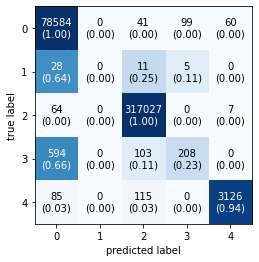

In [173]:
cmat_ad = confusion_matrix(tf.argmax(y_test_small,axis=1), tf.argmax(adam_small_pred,axis=1))

plot_confusion_matrix(
    conf_mat = cmat_ad,
    show_normed = True
)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

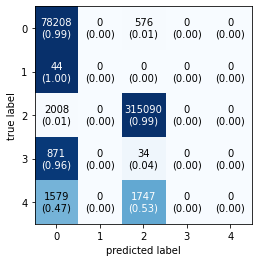

In [174]:
cmat_nag_1 = confusion_matrix(tf.argmax(y_test_small,axis=1), tf.argmax(nag_1_small_pred,axis=1))

plot_confusion_matrix(
    conf_mat = cmat_nag_1,
    show_normed = True
)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

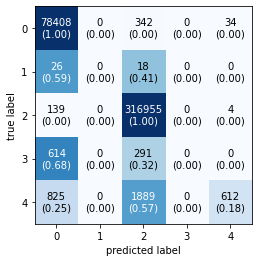

In [177]:
cmat_nag_2 = confusion_matrix(tf.argmax(y_test_small,axis=1), tf.argmax(nag_2_small_pred,axis=1))

plot_confusion_matrix(
    conf_mat = cmat_nag_2,
    show_normed = True
)

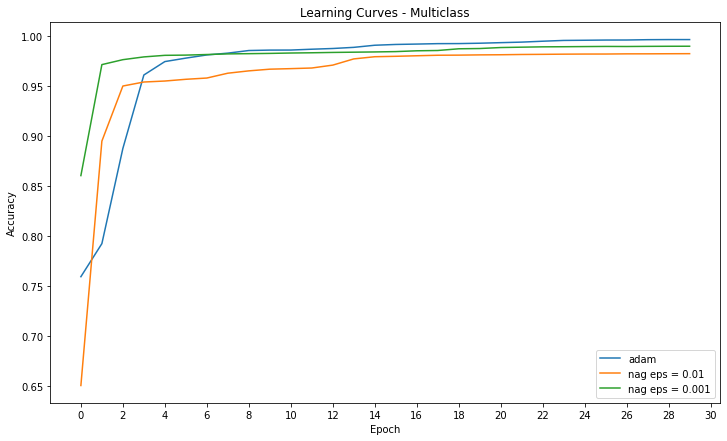

In [143]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,31,2))
plt.ylabel('Accuracy')

plt.plot(sm_adam_hist.history['accuracy'],label='adam')
plt.plot(sm_nag_hist_1.history['accuracy'],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['accuracy'],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

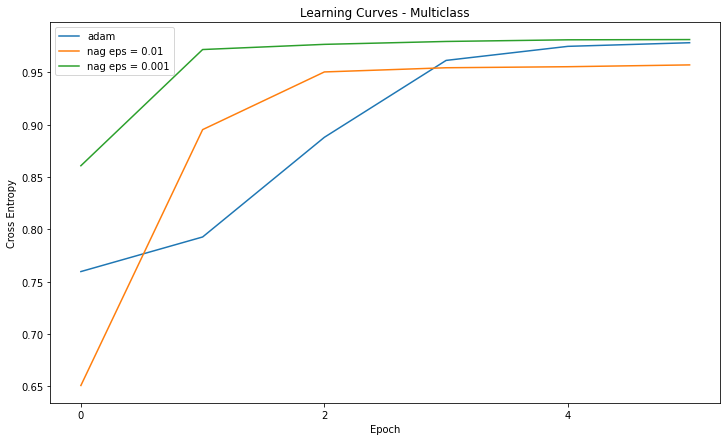

In [145]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,31,2))
plt.ylabel('Cross Entropy')

plt.plot(sm_adam_hist.history['accuracy'][:6],label='adam')
plt.plot(sm_nag_hist_1.history['accuracy'][:6],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['accuracy'][:6],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

#### Plot (Unstratified)

Plot adam vs NAG $\epsilon$ = 0.01 vs NAG $\epsilon$ = 0.001 for the multiclass classifier case

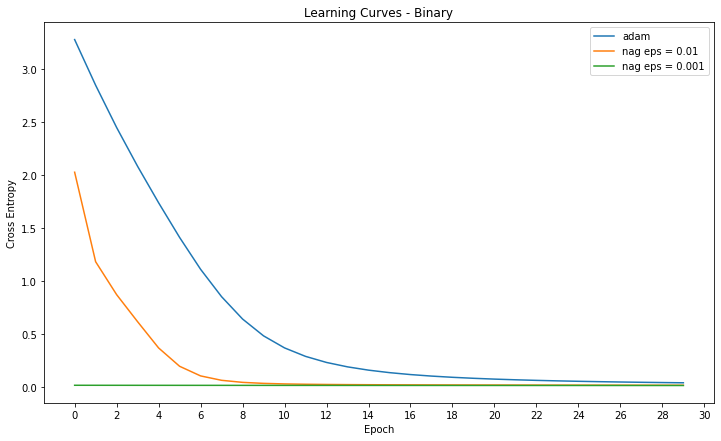

In [51]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,31,2))
plt.ylabel('Cross Entropy')

plt.plot(sm_adam_hist.history['loss'],label='adam')
plt.plot(sm_nag_hist_1.history['loss'],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Inspect first 20 epochs

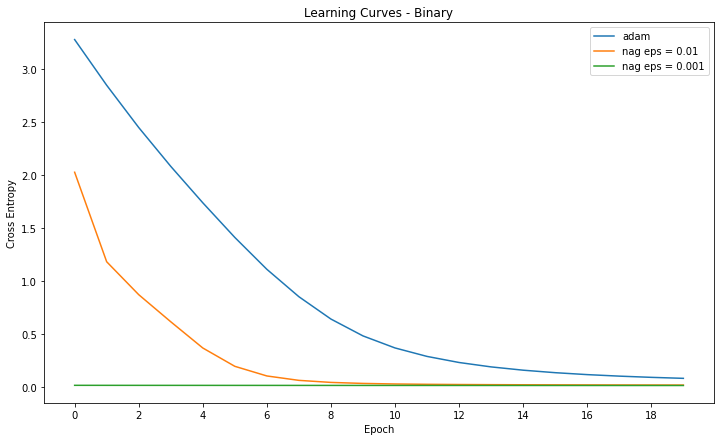

In [52]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,30,2))
plt.ylabel('Cross Entropy')

plt.plot(sm_adam_hist.history['loss'][:20],label='adam')
plt.plot(sm_nag_hist_1.history['loss'][:20],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['loss'][:20],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

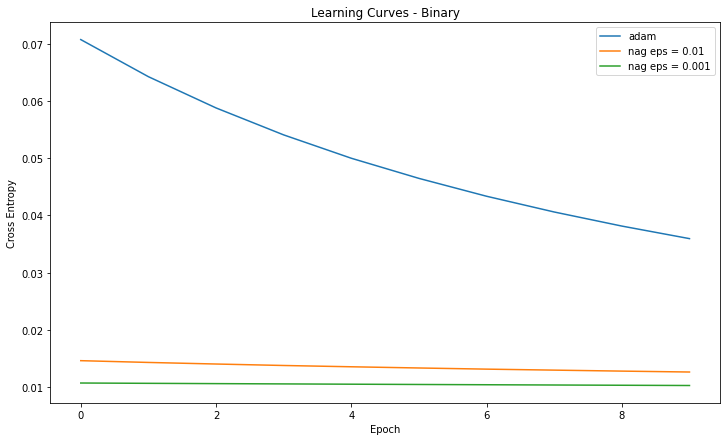

In [53]:
fig = plt.figure(figsize=(12,7))

plt.title('Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,20,2))
plt.ylabel('Cross Entropy')

plt.plot(sm_adam_hist.history['loss'][20:],label='adam')
plt.plot(sm_nag_hist_1.history['loss'][20:],label='nag eps = 0.01')
plt.plot(sm_nag_hist_2.history['loss'][20:],label='nag eps = 0.001')
# plt.plot(history_nag_3.history['loss'],label='nag eps = 0.001')
# plt.plot(history_nag_4.history['loss'],label='nag eps = 0.0001')

plt.legend()
plt.show()

Prediction

In [56]:
ad_pred = sm_adam.predict(X_test)
nag_pred = sm_nag.predict(X_test)

In [70]:
len(ad_pred)

49403

In [72]:
tf.argmax(input=ad_pred,axis=0)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([  737, 34393, 48681, 34484, 34393], dtype=int64)>

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [73]:
ad_pred_cm = ad_pred

confusion_matrix(tf.argmax(y_test_multi,axis=1),tf.argmax(ad_pred,axis=1))

array([[ 9740,     0,     0,     0,     0],
       [39128,     0,     0,     0,     0],
       [  120,     0,     0,     0,     0],
       [  412,     0,     0,     0,     0],
       [    3,     0,     0,     0,     0]], dtype=int64)

In [74]:
confusion_matrix(tf.argmax(y_test_multi,axis=1),tf.argmax(nag_pred,axis=1))

array([[ 9740,     0,     0,     0,     0],
       [39128,     0,     0,     0,     0],
       [  120,     0,     0,     0,     0],
       [  404,     0,     4,     4,     0],
       [    3,     0,     0,     0,     0]], dtype=int64)